# Tratamento de Dados de Renda - SICLI
--- 
Importar a biblioteca Pandas para manipulação dos dados em formato tabular.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime 

In [2]:
pd.set_option('float_format', '{:0.2f}'.format)

Leitura do arquivo `cli_amostra_minas_gerais_202006051503.csv` contendo informações de renda dos clientes de Minas Gerais.  
Para a geração deste arquivo, foi executado o [script sql](http://fontes.des.caixa/GESIR/gesir-solucoes-analiticas/ibge-indicadores-censitarios/blob/master/selecao-amostra-sicli/amostra_minas_gerais.sql#L103) utilizando os filtros de "**sg_uf = 'MG'**", "**aa_fim isnull**" e "**ic_comprovacao = 'S'**".

In [3]:
arquivo = '../dados/amostra_sicli/cli_amostra_minas_gerais_202006051503.csv'
sep = ';'

In [4]:
df_renda = pd.read_csv(arquivo, sep=sep)

In [5]:
df_renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251240 entries, 0 to 4251239
Data columns (total 20 columns):
 #   Column              Dtype  
---  ------              -----  
 0   nu_pessoa           int64  
 1   dt_nascimento       object 
 2   ic_tipo_renda       object 
 3   vr_renda_bruta      float64
 4   vr_renda_liquida    float64
 5   dt_inicio           object 
 6   dt_fim              float64
 7   ic_principal        float64
 8   nu_tipo_renda_p76   float64
 9   no_atividade        object 
 10  de_local_trabalho   object 
 11  ic_infmo_renda      float64
 12  dt_apuracao_renda   object 
 13  ic_sexo             object 
 14  ic_situacao         int64  
 15  ic_inconsistencia   object 
 16  nu_estdo_civil_p27  int64  
 17  de_estado_civil     int64  
 18  nu_nivel_insto_p14  float64
 19  de_nivel_instrucao  float64
dtypes: float64(8), int64(4), object(8)
memory usage: 648.7+ MB


### Lista de colunas que serão desconsideradas em conformidade com:  
http://fontes.des.caixa/GESIR/gesir-solucoes-analiticas/ibge-indicadores-censitarios/wikis/3.2.1.-qualidade-de-dados

In [6]:
#features_drop=['dt_inicio','dt_fim','no_atividade','de_local_trabalho','dt_apuracao_renda','ic_situacao',
### dt_apuracao_renda foi incluído visando ser utilizado no modelo que estima a faixa de renda
features_drop=['dt_inicio','dt_fim','no_atividade','de_local_trabalho','ic_situacao',
              'ic_inconsistencia','nu_nivel_insto_p14','de_nivel_instrucao']
df_renda.drop(features_drop,axis=1,inplace=True)

In [7]:
df_renda.columns

Index(['nu_pessoa', 'dt_nascimento', 'ic_tipo_renda', 'vr_renda_bruta',
       'vr_renda_liquida', 'ic_principal', 'nu_tipo_renda_p76',
       'ic_infmo_renda', 'dt_apuracao_renda', 'ic_sexo', 'nu_estdo_civil_p27',
       'de_estado_civil'],
      dtype='object')

In [8]:
features_renda = ['vr_renda_bruta','vr_renda_liquida']
features = ['nu_pessoa', 'dt_nascimento', 'ic_tipo_renda', 
            'ic_principal', 'nu_tipo_renda_p76', 'ic_infmo_renda', 
            'ic_sexo', 'nu_estdo_civil_p27', 'de_estado_civil']

features_all = ['nu_pessoa', 'dt_apuracao_renda', 'dt_nascimento', 'ic_tipo_renda', 
            'ic_principal', 'nu_tipo_renda_p76', 'ic_infmo_renda', 
            'ic_sexo', 'nu_estdo_civil_p27', 'de_estado_civil', 
            'vr_renda_bruta','vr_renda_liquida']

### Relatório antes de tratar missing values

In [9]:
#pandas_profiling.ProfileReport(df_renda[features])

### Tratar dt_nascimento e criar idade
1. Parse de validação e formatação de data    
   - Sobre `format='%Y-%m-%d'` e `errors='coerce'` em https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html  
2. Eliminar os casos nulos em data de nascimento  
3. Criar a idade  
   - Sobre `<m8[Y]` em https://stackoverflow.com/questions/29206612/difference-between-data-type-datetime64ns-and-m8ns
4. Considerar idades onde 18 <= idade <= 110  

In [10]:
now = pd.Timestamp('now') # gera data atual
# etapa 1
df_renda['dt_nascimento'] = pd.to_datetime(df_renda['dt_nascimento'], format='%Y-%m-%d', errors='coerce')
# etapa 2
df_renda.dropna(subset=['dt_nascimento'], inplace=True)
# etapa 3
df_renda['idade'] = (now - df_renda['dt_nascimento']).astype('<m8[Y]').astype('int')
# etapa 4
df_renda = df_renda[(df_renda['idade']>=18) & (df_renda['idade']<=110)].reset_index(drop=True)

In [11]:
features.append('idade')
features_all.append('idade')

#### ic_tipo_renda
- Susbtituir NaN por `?`

In [12]:
df_renda["ic_tipo_renda"].fillna('?',inplace=True)

#### ic_principal
- Susbtituir NaN por `?`

In [13]:
df_renda["ic_principal"].fillna('0',inplace=True)

#### nu_tipo_renda_p76
- Susbtituir `NaN` por `8` em conformidade com:  
http://fontes.des.caixa/GESIR/gesir-solucoes-analiticas/ibge-indicadores-censitarios/wikis/3.2.1.-qualidade-de-dados

In [14]:
df_renda["nu_tipo_renda_p76"].fillna('8',inplace=True)

#### ic_infmo_renda
- Susbtituir `NaN` por `0`

In [15]:
df_renda["ic_infmo_renda"].fillna(0,inplace=True)

#### ic_sexo
- Susbtituir `NaN` por `?`

In [16]:
df_renda["ic_sexo"].fillna('?',inplace=True)

### Tratar **`outliers`** em **`vr_renda_bruta`** e **`vr_renda_liquida`**
- Registros com **`renda = 0`** serão desconsiderados
#### Função para gerar gráficos de análise de outliers

In [17]:
def diagnostic_number_plots(df):
    for v in df:
        if pd.api.types.is_numeric_dtype(df[v]) == True:
            # define figure size
            plt.figure(figsize=(16, 4))

            # histogram
            plt.subplot(1, 3, 1)
            sns.distplot(df[v], bins=30)
            plt.title('Histogram')

            # Q-Q plot
            plt.subplot(1, 3, 2)
            stats.probplot(df[v], dist="norm", plot=plt)
            plt.ylabel(v+' quantiles')

            # boxplot
            plt.subplot(1, 3, 3)
            sns.boxplot(y=df[v])
            plt.title('Boxplot')

            plt.show()

Análise do estado dos dados **antes** de retirar os **`outliers`**.

In [18]:
df_renda[features_renda].describe(include=[np.number], percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99])

,vr_renda_bruta,vr_renda_liquida
count,2500108.00,2500108.00
mean,26337.53,4947464.90
std,22577701.11,1968549601.02
min,0.00,0.00
1%,0.00,0.00
5%,0.00,0.00
10%,0.00,0.00
25%,0.00,0.00
50%,240.00,450.00
75%,1045.00,1100.00


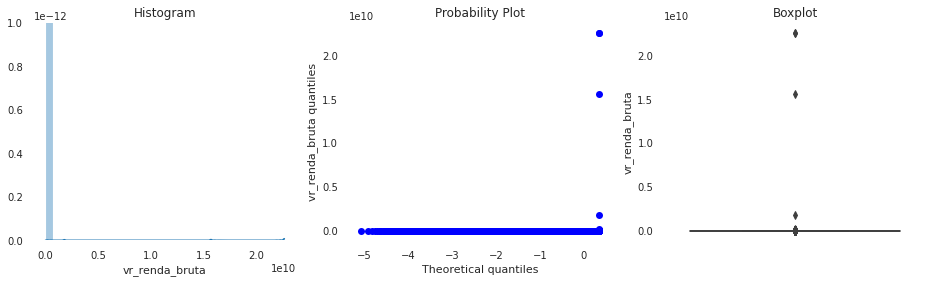

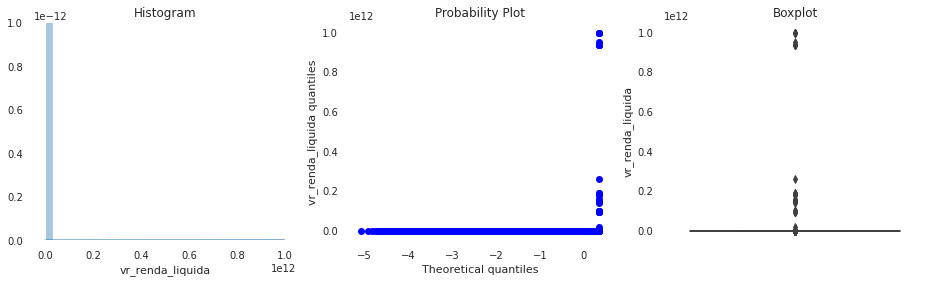

In [19]:
diagnostic_number_plots(df_renda[features_renda])

#### Valores `NaN` serão convertidos para `0`

In [20]:
df_renda['vr_renda_bruta'].fillna(0,inplace=True)
df_renda['vr_renda_liquida'].fillna(0,inplace=True)

In [21]:
print('Qtd:   %s' % df_renda[['vr_renda_bruta']][df_renda['vr_renda_bruta']==0].count())
print('Qtd: %s' % df_renda[['vr_renda_liquida']][df_renda['vr_renda_liquida']==0].count())

Qtd:   vr_renda_bruta    2543771
dtype: int64
Qtd: vr_renda_liquida    2275547
dtype: int64


- É bem significativa a quantidade de registros que contém **`0`** em renda bruta e líquida;
- Portanto, os registros com **`0`** serão retirados para que a dispersão não seja enviezada a menor e, assim, os registros ficam sem distorções sobre as rendas.

Retirar os casos de **`renda = 0`**

In [22]:
df_renda[['vr_renda_bruta']] = df_renda[['vr_renda_bruta']][df_renda['vr_renda_bruta'] > 0]

In [23]:
df_renda[['vr_renda_liquida']] = df_renda[['vr_renda_liquida']][df_renda['vr_renda_liquida'] > 0]

Distribuição por percentil **após** desconsiderar **`renda = 0`**

In [24]:
df_renda[features_renda].describe(include=[np.number], percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99])

,vr_renda_bruta,vr_renda_liquida
count,1358818.00,1627042.00
mean,48458.79,7602260.16
std,30625154.15,2440201420.80
min,0.01,0.01
1%,2.00,1.00
5%,199.00,180.00
10%,250.00,250.00
25%,510.00,500.00
50%,1000.00,952.05
75%,1769.84,1500.00


### Gera arquivo tratado COM OUTLIERS

In [25]:
# Gera arquivo tratado COM OUTLIERS
df_renda[features_all].to_csv('../dados/amostra_sicli_tratada/cli_renda_amostra_MG_validos_COM_outliers.csv',
                              index=False, encoding='utf-8', sep=';')

### Como serão tratados os outliers?
Valores **`x%` acima** do `terceiro quartil` e os valores **`x%` abaixo** do `segundo quartil` **serão considerados** `outliers`.  

Função que calcula o **`limite superior`** dos **`outlier`**.

In [26]:
def find_boundaries_upper(df, variable, distance):
    # distance: std = 0.1 até 3.0

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary

Função que calcula o **`limite inferior`** dos **`outlier`**.

In [27]:
def find_boundaries_lower(df, variable, distance):
    # distance: std = 0.1 até 3.0

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)

    return lower_boundary

Parametrização dos **`outliers`** em **`renda bruta`** por porcentagem **acima** e **abaixo** do **desvio padrão**.

In [28]:
vr_renda_bruta_upper_limit = find_boundaries_upper(df_renda,'vr_renda_bruta', 3.0)
vr_renda_bruta_lower_limit = find_boundaries_lower(df_renda,'vr_renda_bruta', 0.325)

vr_renda_bruta_upper_limit, vr_renda_bruta_lower_limit

(5549.36, 100.55200000000002)

Parametrização dos **`outliers`** em **`renda líquida`** por porcentagem **acima** e **abaixo** do **desvio padrão**.

In [29]:
vr_renda_liquida_upper_limit = find_boundaries_upper(df_renda,'vr_renda_liquida', 3.0)
vr_renda_liquida_lower_limit = find_boundaries_lower(df_renda,'vr_renda_liquida', 0.4)

vr_renda_liquida_upper_limit, vr_renda_liquida_lower_limit

(4500.0, 100.0)

In [30]:
df_trimmed = df_renda[
                (df_renda['vr_renda_liquida']>=vr_renda_liquida_lower_limit) & 
                (df_renda['vr_renda_bruta']>=vr_renda_bruta_lower_limit) & 
                (df_renda['vr_renda_liquida']<=vr_renda_liquida_upper_limit) & 
                (df_renda['vr_renda_bruta']<=vr_renda_bruta_upper_limit)
            ].reset_index(drop=True)

### Relatório após tratar missing values

In [31]:
df_trimmed[features_renda].describe(include=[np.number], percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99])

,vr_renda_bruta,vr_renda_liquida
count,1210298.00,1210298.00
mean,1252.77,1118.84
std,952.57,815.19
min,100.80,100.00
1%,163.50,160.00
5%,240.00,234.00
10%,300.00,280.00
25%,545.41,520.00
50%,1000.00,950.00
75%,1645.63,1466.00


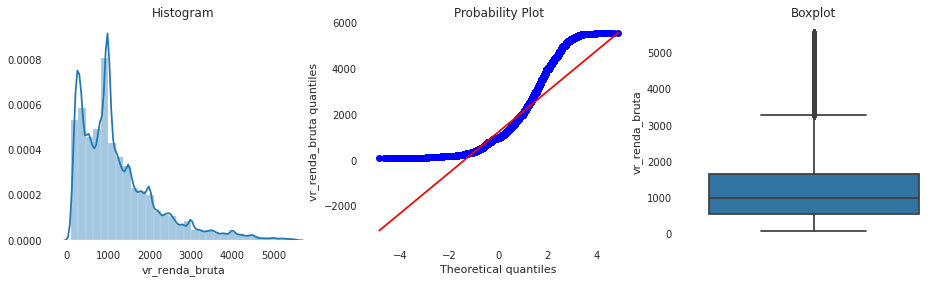

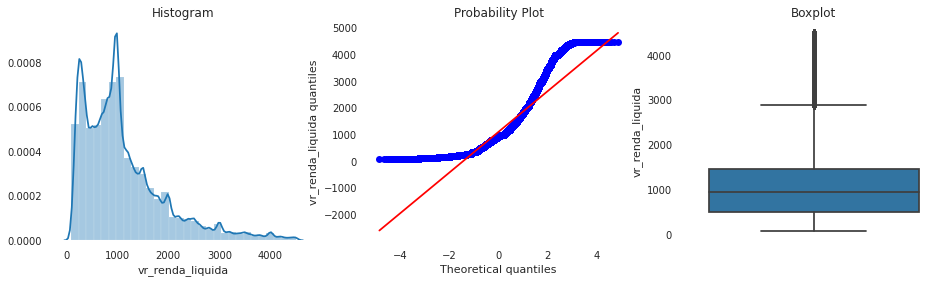

In [32]:
diagnostic_number_plots(df_trimmed[features_renda])

### Gerar arquivo **sem `outliers`** em renda bruta e renda líquida.

In [33]:
df_renda[features_all].to_csv('../dados/amostra_sicli_tratada/cli_renda_amostra_MG_validos_sem_outliers.csv',
                              index=False, encoding='utf-8', sep=';')

In [34]:
df_trimmed.corr(method='pearson')

,nu_pessoa,vr_renda_bruta,vr_renda_liquida,nu_estdo_civil_p27,de_estado_civil,idade
nu_pessoa,1.00,-0.00,-0.00,-0.01,0.01,-0.02
vr_renda_bruta,-0.00,1.00,0.94,0.05,0.41,-0.20
vr_renda_liquida,-0.00,0.94,1.00,0.05,0.38,-0.17
nu_estdo_civil_p27,-0.01,0.05,0.05,1.00,0.05,0.23
de_estado_civil,0.01,0.41,0.38,0.05,1.00,-0.43
idade,-0.02,-0.20,-0.17,0.23,-0.43,1.00


In [35]:
df_trimmed.skew()

nu_pessoa             0.04
vr_renda_bruta        1.48
vr_renda_liquida      1.45
ic_principal          0.73
nu_tipo_renda_p76    -3.33
ic_infmo_renda       -0.99
nu_estdo_civil_p27    0.93
de_estado_civil      -0.47
idade                 0.54
dtype: float64

In [36]:
df_trimmed.describe()

,nu_pessoa,vr_renda_bruta,vr_renda_liquida,nu_estdo_civil_p27,de_estado_civil,idade
count,1210298.00,1210298.00,1210298.00,1210298.00,1210298.00,1210298.00
mean,4927446375447.18,1252.77,1118.84,3.13,5.15,50.47
std,2878395839270.07,952.57,815.19,3.05,2.85,18.83
min,10000055001.00,100.80,100.00,0.00,0.00,18.00
25%,2390075103489.00,545.41,520.00,1.00,2.00,36.00
50%,4900021016990.00,1000.00,950.00,1.00,6.00,48.00
75%,7440135554244.00,1645.63,1466.00,5.00,7.00,63.00
max,9990238382999.00,5549.13,4500.00,9.00,12.00,110.00


In [37]:
features_trim = ['nu_pessoa', 'dt_nascimento', 'ic_tipo_renda', 'vr_renda_bruta',
       'vr_renda_liquida', 'ic_principal', 'nu_tipo_renda_p76',
       'ic_infmo_renda', 'ic_sexo', 'nu_estdo_civil_p27', 'de_estado_civil',
       'idade']
#label_trim = ['ic_sexo','nu_estdo_civil_p27','de_estado_civil']
label_trim = ['nu_estdo_civil_p27','de_estado_civil']

In [38]:
df_trimmed['ic_sexo'].value_counts().head()

M    654731
F    554006
?      1561
Name: ic_sexo, dtype: int64

In [39]:
df_trimmed['nu_estdo_civil_p27'].value_counts().head()

1    596401
9    157383
7    101611
2     88659
0     75480
Name: nu_estdo_civil_p27, dtype: int64

In [40]:
df_trimmed['de_estado_civil'].value_counts().head()

7    408385
2    144972
0    138144
9    108023
5    105350
Name: de_estado_civil, dtype: int64

In [41]:
from sklearn.model_selection import train_test_split

X, y = df_trimmed[features_trim], df_trimmed[label_trim]
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      test_size=0.985,
                      random_state=0,
                      stratify=y)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(18154, 12) (18154, 2)
(1192144, 12) (1192144, 2)


In [42]:
df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210298 entries, 0 to 1210297
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   nu_pessoa           1210298 non-null  int64         
 1   dt_nascimento       1210298 non-null  datetime64[ns]
 2   ic_tipo_renda       1210298 non-null  object        
 3   vr_renda_bruta      1210298 non-null  float64       
 4   vr_renda_liquida    1210298 non-null  float64       
 5   ic_principal        1210298 non-null  object        
 6   nu_tipo_renda_p76   1210298 non-null  object        
 7   ic_infmo_renda      1210298 non-null  object        
 8   dt_apuracao_renda   1055941 non-null  object        
 9   ic_sexo             1210298 non-null  object        
 10  nu_estdo_civil_p27  1210298 non-null  int64         
 11  de_estado_civil     1210298 non-null  int64         
 12  idade               1210298 non-null  int64         
dtypes: datetime6